# Relationship Extraction

In this notebook, we will implement a Relation Extraction Model using BERT and Pytorch.

### Data

* Data for fine-tuning the RE comes from the [New York Times (NYT) Relation Extraction Dataset](https://www.kaggle.com/datasets/daishinkan002/new-york-times-relation-extraction-dataset) available on Kaggle.Each sentence can have more than 1 relation.
* This dataset contains 24 types of relations that may occur in a sentence.
  * /location/location/contains
  * /people/person/nationality
  * /people/person/place_lived
  * /business/person/company
  * /location/country/capital
  * /location/neighborhood/neighborhood_of
  * /people/person/placeofbirth
  * /location/country/administrative_divisions
  * /location/administrative_division/country
  * /people/deceasedperson/placeof_death
  * /people/person/children
  * /business/company/founders
  * /business/company/place_founded
  * /business/companyshareholder/majorshareholder_of
  * /sports/sportsteamlocation/teams
  * /sports/sports_team/location
  * /business/company/major_shareholders
  * /people/person/religion
  * /business/company/advisors
  * /people/ethnicity/geographic_distribution
  * /people/person/ethnicity
  * /people/ethnicity/people
  * /people/person/profession
  * /business/company/industry
* The relationships connect three different entity types PERSON, LOCATION and ORGANIZATION. 

### Model

* Unlike the `XXXForTokenClassification` model, which comes with a standard token classification head on top of some XXX transformer, there is no pre-built model available OOB at HuggingFace for Relation Extraction.
* So we will build our own `XXXForRelationExtraction` model by composing a pretrained Transformer encoder with a classification head for classifying the relation type.

## Environment Setup

In [ ]:
!pip install transformers datasets seqeval

## Imports

In [ ]:
import collections
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
import re
import shutil
import torch
import torch.nn as nn

from collections import Counter, defaultdict
from datasets import load_dataset, ClassLabel
from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix, 
    classification_report, accuracy_score
)
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.optim import AdamW

from transformers import (
    BertTokenizerFast, BertModel, BertForPreTraining, BertConfig, BertPreTrainedModel,
    DataCollatorWithPadding,
    get_scheduler
)
from transformers.modeling_outputs import SequenceClassifierOutput

## Data Processing

### Mount Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
GS_INPUT_DIR = "/content/drive/MyDrive/odsc-2022-data/NYT"
DATA_DIR = "./data"

BASE_MODEL_NAME = "bert-base-cased"
MODEL_DIR = os.path.join(DATA_DIR, "{:s}-nyt-re-v1".format(BASE_MODEL_NAME))

In [ ]:
!ls /content/drive/MyDrive/odsc-2022-data/NYT/

bert-base-cased-nyt-re	test.json  train.json  valid.json


### Input Data Format

Our dataset is pre-partitioned into train, validation and test splits.

The `relationMentions` tag lists the relations and matched text of the entities, and the corresponding entity types can be found in the `entityMentions` tag.

The sentence text can be found in `sentText`.


In [ ]:
with open(os.path.join(GS_INPUT_DIR, "train.json"), "r") as fin:
  for line in fin:
    rec = json.loads(line.strip())
    break

print(json.dumps(rec, indent=2))

{
  "sentText": "Massachusetts ASTON MAGNA Great Barrington ; also at Bard College , Annandale-on-Hudson , N.Y. , July 1-Aug .",
  "articleId": "/m/vinci8/data1/riedel/projects/relation/kb/nyt1/docstore/nyt-2005-2006.backup/1669365.xml.pb",
  "relationMentions": [
    {
      "em1Text": "Annandale-on-Hudson",
      "em2Text": "Bard College",
      "label": "/location/location/contains"
    }
  ],
  "entityMentions": [
    {
      "start": 1,
      "label": "ORGANIZATION",
      "text": "Bard College"
    },
    {
      "start": 2,
      "label": "LOCATION",
      "text": "Annandale-on-Hudson"
    }
  ],
  "sentId": "1"
}


## Entity Types

Here we analyze the distribution of entity tags across the different splits, and find that it is approximately uniform across the splits.

In [ ]:
splits = ["train", "valid", "test"]
ent_counts = collections.defaultdict(collections.Counter)
for split in splits:
  with open(os.path.join(GS_INPUT_DIR, "{:s}.json".format(split)), "r") as fin:
    for json_line in fin:
      json_dict = json.loads(json_line.strip())
      for ent_mention in json_dict["entityMentions"]:
        label = ent_mention["label"]
        ent_counts[label][split] += 1

ent_df = pd.DataFrame.from_dict(ent_counts, orient="index").sort_values("train", ascending=False)
ent_df

,train,valid,test
LOCATION,119693,10703,10721
PERSON,41367,3727,3727
ORGANIZATION,16401,1493,1413


## Relation Types

We analyze the distribution of relation types across different splits, and we find that while the distribution is uniform across splits, the distribution is very uneven across different relation types.

Here we discard the relation types that are very heavily represented and those which are very lightly represented by filtering our dataset such that only relations with train split counts between 1000 and 10000 are retained.

In real life, we might want to structure our relation extraction pipeline into a hierarchy of models to reflect a more uniform split, or do over/undersampling to attempt to make the dataset less imbalanced, or reduce the model into a set of binary classifiers. But here we take the easy way out and discard relations that are outside the range.

In [ ]:
rel_counts = collections.defaultdict(collections.Counter)
for split in splits:
  with open(os.path.join(GS_INPUT_DIR, "{:s}.json".format(split)), "r") as fin:
    for json_line in fin:
      json_dict = json.loads(json_line.strip())
      for ent_mention in json_dict["relationMentions"]:
        label = ent_mention["label"].split("/")[-1]
        rel_counts[label][split] += 1

rel_df = pd.DataFrame.from_dict(rel_counts, orient="index").sort_values("train", ascending=False)
rel_df = rel_df[(rel_df["train"] > 1000) & (rel_df["train"] < 10000)]
rel_df

,train,valid,test
nationality,7198,643.0,589.0
capital,6718,616.0,708.0
place_lived,6362,539.0,612.0
country,5658,558.0,580.0
administrative_divisions,5658,558.0,580.0
company,4950,466.0,436.0
neighborhood_of,4941,469.0,394.0
place_of_birth,2813,228.0,270.0
place_of_death,1752,133.0,136.0


## Raw Dataset

We introduce entity marker tags that wrap the entity mentions in the sentence. For example, the sentence:

```Washington DC is the capital of the United States .```

is converted to:

```<S:LOC> Washington DC </S:LOC> is the capital of the <O:LOC> United States </O:LOC> .```

We read the input data and write out the augmented sentence using the information from `sentText`, `entityMentions` and `relationMentions` and tokenize them (by space). Also, we extract the relation type from `relationMentions`. The temporary JSON files have records with the following keys: `{"tokens", "label"}`

This is then converted to a raw HuggingFace dataset using the `load_dataset` function.

In [ ]:
def reformat_json(infile, outfile, valid_relations):
  print("reformating {:s} -> {:s}".format(infile, outfile))
  fout = open(outfile, "w")
  with open(infile, "r") as fin:
    for line in fin:
      rec = json.loads(line.strip())
      text = rec["sentText"]
      entities = {}
      for entity_mention in rec["entityMentions"]:
        entity_text = entity_mention["text"]
        entity_type = entity_mention["label"][0:3]
        entities[entity_text] = entity_type
      for relation_mention in rec["relationMentions"]:
        label = relation_mention["label"].split("/")[-1]
        if label not in valid_relations:
          continue
        try:
          sub_text = relation_mention["em1Text"]
          sub_type = entities[sub_text]
          obj_text = relation_mention["em2Text"]
          obj_type = entities[obj_text]
          
          # assumption: em1Text == SUBJECT and occurs before em2Text == OBJECT
          sub_start = text.find(sub_text)
          sub_end = sub_start + len(sub_text)
          text_pre = text[:sub_start]
          text_sub = "<S:{:s}> {:s} </S:{:s}>".format(sub_type, sub_text, sub_type)
          obj_start = text.find(obj_text, sub_end)
          obj_end = obj_start + len(obj_text)
          text_mid = text[sub_end:obj_start]
          text_obj = "<O:{:s}> {:s} </O:{:s}>".format(obj_type, obj_text, obj_type)
          text_post = text[obj_end:]
          text = text_pre + text_sub + text_mid + text_obj + text_post

          tokens = text.split()
          output = {
              "tokens": tokens,
              "label": label
          }
          
          fout.write(json.dumps(output) + "\n")
        except:
          pass
  fout.close()


os.makedirs(DATA_DIR, exist_ok=True)

valid_relations = set([
  "nationality", "capital", "place_lived", "country", "administrative_divisions",
  "company", "neighborhood_of", "place_of_birth", "place_of_death"
])

for i, split in enumerate(splits):
  reformat_json(os.path.join(GS_INPUT_DIR, "{:s}.json".format(split)),
                os.path.join(DATA_DIR, "{:s}.json".format(split)), 
                valid_relations=valid_relations)

reformating /content/drive/MyDrive/odsc-2022-data/NYT/train.json -> ./data/train.json
reformating /content/drive/MyDrive/odsc-2022-data/NYT/valid.json -> ./data/valid.json
reformating /content/drive/MyDrive/odsc-2022-data/NYT/test.json -> ./data/test.json


In [ ]:
data_files = {split: os.path.join(DATA_DIR, "{:s}.json".format(split)) for split in splits}
nyt_dataset = load_dataset("json", data_files=data_files)
nyt_dataset

Using custom data configuration default-0abcfaa610463dc9


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-0abcfaa610463dc9/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'label'],
        num_rows: 45860
    })
    valid: Dataset({
        features: ['tokens', 'label'],
        num_rows: 4182
    })
    test: Dataset({
        features: ['tokens', 'label'],
        num_rows: 4277
    })
})

### Label Distribution

Even with the filtering, the label distribution is not uniform. However, it is not as bad as it would be if no filtering was done.

In [ ]:
nyt_dataset.set_format(type="pandas")
nyt_df = nyt_dataset["train"][:]
nyt_df.head()

,tokens,label
0,"[It, will, be, the, final, movie, credited, to...",place_of_birth
1,"[Under, pressure, from, Mr., Kerkorian, and, o...",company
2,"[Mr., Ferrer, still, holds, commanding, leads,...",place_lived
3,"[Mr., Ferrer, still, holds, commanding, leads,...",place_lived
4,"[United, States, Representative, <S:PER>, Char...",place_of_birth


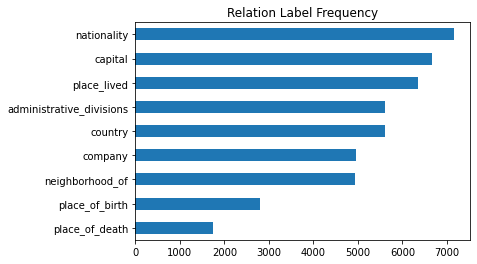

In [ ]:
nyt_df["label"].value_counts(ascending=True).plot.barh()
plt.title("Relation Label Frequency")
_ = plt.show()

### Sentence Length Distribution

We were encountering errors where we were running out of CUDA Memory. This was happening even when I reduced the batch size from 32 to 8. The other reason this could be happening is that some batches might contain very long outlier sentences and this causes the batch to be too big for the GPU memory.

Solution is to truncate the sentence size to a size that will not impact the accuracy too much. 

The box plots below shows that we can safely ignore sentences that are over 100 tokens in length.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


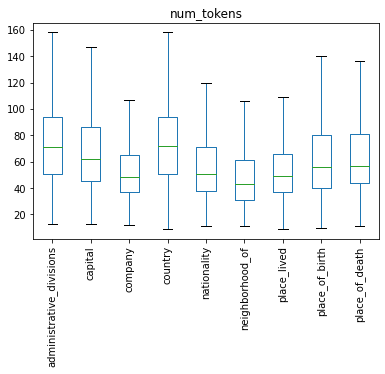

In [ ]:
nyt_df["num_tokens"] = nyt_df["tokens"].apply(len)
nyt_df.boxplot("num_tokens", by="label", grid=False, showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.xticks(rotation=90)
_ = plt.show()

In [ ]:
nyt_dataset.reset_format()

## Tokenizer

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained(BASE_MODEL_NAME)

### Add Entity Marker Tokens

Now that we added these entity marker tokens, we need to tell the tokenizer to treat them as unbreakable tokens, so we add these tokens to our tokenizer.

In [ ]:
marker_tokens = []
entity_types = ["LOC", "PER", "ORG"]
for entity_type in entity_types:
  marker_tokens.append("<S:{:s}>".format(entity_type))
  marker_tokens.append("</S:{:s}>".format(entity_type))
  marker_tokens.append("<O:{:s}>".format(entity_type))
  marker_tokens.append("</O:{:s}>".format(entity_type))

tokenizer.add_tokens(marker_tokens)

12

## Encoded Dataset

As before, we create an encoded dataset that contains the output of the tokenizer and numeric labels.

To compute numeric labels, we create a `ClassLabel` object with our relation tags, and use its built-in functions to create lookup tables from label to label id and vice versa.

We discard sentences that are larger than `MAX_TOKENS` which we have decided should be 100 tokens (these are space delimited tokens prior to subword tokenization).

In addition, we also compute and store the value of the entity marker tokens with respect to the positions _after subword tokenization_. This is written into a fixed size int vector consisting of 4 elements, and stored under the `span_idxs` key.

In [ ]:
valid_relations = sorted(list(valid_relations))
rel_tags = ClassLabel(names=valid_relations)
label2id = {name: rel_tags.str2int(name) for name in valid_relations}
id2label = {id: rel_tags.int2str(id) for id in range(len(valid_relations))}

# label2id, id2label

In [ ]:
def encode_data(examples):
  tokenized_inputs = tokenizer(examples["tokens"],
                               is_split_into_words=True,
                               truncation=True)
  span_idxs = []
  for input_id in tokenized_inputs.input_ids:
    tokens = tokenizer.convert_ids_to_tokens(input_id)
    span_idxs.append([
      [idx for idx, token in enumerate(tokens) if token.startswith("<S:")][0],
      [idx for idx, token in enumerate(tokens) if token.startswith("</S:")][0],
      [idx for idx, token in enumerate(tokens) if token.startswith("<O:")][0],
      [idx for idx, token in enumerate(tokens) if token.startswith("</O:")][0]
    ])
  tokenized_inputs["span_idxs"] = span_idxs
  tokenized_inputs["labels"] = [label2id[label] for label in examples["label"]]
  return tokenized_inputs

encoded = encode_data(nyt_dataset["train"][0:5])
encoded.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'span_idxs', 'labels'])

In [ ]:
MAX_LENGTH = 100
encoded_nyt_dataset = (nyt_dataset
                       .filter(lambda example: len(example["tokens"]) < MAX_LENGTH)
                       .map(encode_data, batched=True, remove_columns=["tokens", "label"]))
encoded_nyt_dataset

  0%|          | 0/46 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/41 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'span_idxs', 'labels'],
        num_rows: 40126
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'span_idxs', 'labels'],
        num_rows: 3656
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'span_idxs', 'labels'],
        num_rows: 3713
    })
})

In [ ]:
rec = encoded_nyt_dataset["train"][0:5]
print("rec.labels:", rec["labels"])
print("rec.input_ids:", len(rec["input_ids"]), len(rec["input_ids"][0]))
print("rec.span_idxs:", rec["span_idxs"])

rec.labels: [7, 2, 6, 6, 7]
rec.input_ids: 5 44
rec.span_idxs: [[9, 13, 21, 25], [31, 36, 42, 44], [22, 28, 30, 32], [22, 29, 32, 34], [4, 10, 23, 27]]


## DataLoader

As before, we build `DataLoaders` for each of training, validation and test splits by wrapping the corresponding encoded `Dataset`.

We use a `DataColatorWithPadding` data collator to automatically pad our batch with the longest sentence in the batch.

As before, we use the `sampler` trick to do quick development iterations by keeping the data volume down.

In [ ]:
BATCH_SIZE = 16

In [ ]:
collate_fn = DataCollatorWithPadding(tokenizer, padding="longest", return_tensors="pt")

train_dl = DataLoader(encoded_nyt_dataset["train"], 
                      shuffle=True, 
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_nyt_dataset["train"].num_rows, 1000).tolist()),
                      batch_size=BATCH_SIZE, 
                      collate_fn=collate_fn)
valid_dl = DataLoader(encoded_nyt_dataset["valid"], 
                      shuffle=False, 
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_nyt_dataset["valid"].num_rows, 200).tolist()),
                      batch_size=BATCH_SIZE, 
                      collate_fn=collate_fn)
test_dl = DataLoader(encoded_nyt_dataset["test"], 
                     shuffle=False,
                    #  sampler=SubsetRandomSampler(np.random.randint(0, encoded_nyt_dataset["test"].num_rows, 100).tolist()),
                     batch_size=BATCH_SIZE, 
                     collate_fn=collate_fn)

## Model

Since HuggingFace does not provide us with a built-in `XXXForRelationExtraction` model, we need to build our own. Our model is based on the implementation described in [A frustratingly easy approach for Entity and Relation Extraction](https://arxiv.org/abs/2010.12812) (Zhong and Chen 2020). The authors also provide code in the github repository [princeton-nlp/PURE](https://github.com/princeton-nlp/PURE) to support their paper, which we have consulted as well when building our model.

The idea is to use a PreTrainedModel as the encoder and a small linear head consisting of `torch.nn.Dropout`, `torch.nn.LayerNorm` and `torch.nn.Linear` layers as the classifier head. The encoder should start with weights from the pretrained model and be fine-tuned from that point using our labeled data.

Since our base model is BERT, we will use a `BertModel` as our encoder and subclass the full model from `BertPreTrainedModel` so we can inherit its weights via the `self.init_weights()` call. When instantiating the model, we will call it with the appropriate `.from_pretrained` to load the weights from the pretrained model.

The `forward` method takes a batch of examples from the encoded dataset, and passes the `input_ids`, `token_type_ids` and `attention_mask` into the BERT encoder (initialized with BertForPreTraining weights). Then the maxpool value across tokens within the entity marker spans (including the entity markers) are computed for the subject and object spans, concatenated and passed into the classifier head.

The classifier head outputs a logits the size of the number of classes, and the argmax over the logits is the predicted relation class.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class BertForRelationExtraction(BertPreTrainedModel):
  def __init__(self, config, num_labels):
    super(BertForRelationExtraction, self).__init__(config)
    self.num_labels = num_labels
    # body
    self.bert = BertModel(config)
    # head
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.layer_norm = nn.LayerNorm(config.hidden_size * 2)
    self.linear = nn.Linear(config.hidden_size * 2, self.num_labels)
    self.init_weights()

  def forward(self, input_ids, token_type_ids, attention_mask,
              span_idxs, labels=None):
    outputs = (
        self.bert(input_ids, token_type_ids=token_type_ids,
                  attention_mask=attention_mask,
                  output_hidden_states=False)
            .last_hidden_state)
            
    sub_maxpool, obj_maxpool = [], []
    for bid in range(outputs.size(0)):
      # span includes entity markers, maxpool across span
      sub_span = torch.max(outputs[bid, span_idxs[bid, 0]:span_idxs[bid, 1]+1, :], 
                           dim=0, keepdim=True).values
      obj_span = torch.max(outputs[bid, span_idxs[bid, 2]:span_idxs[bid, 3]+1, :],
                           dim=0, keepdim=True).values
      sub_maxpool.append(sub_span)
      obj_maxpool.append(obj_span)

    sub_emb = torch.cat(sub_maxpool, dim=0)
    obj_emb = torch.cat(obj_maxpool, dim=0)
    rel_input = torch.cat((sub_emb, obj_emb), dim=-1)

    rel_input = self.layer_norm(rel_input)
    rel_input = self.dropout(rel_input)
    logits = self.linear(rel_input)

    if labels is not None:
      loss_fn = nn.CrossEntropyLoss()
      loss = loss_fn(logits.view(-1, self.num_labels), labels.view(-1))
      return SequenceClassifierOutput(loss, logits)
    else:
      return SequenceClassifierOutput(None, logits)


# config = BertConfig()
# model = BertForRelationExtraction(config, num_labels=len(valid_relations))
# for batch in train_dl:
#   # output = model(batch["input_ids"], batch["token_type_ids"], batch["attention_mask"],
#   #                batch["span_idxs"], batch["labels"])
#   outputs = model(**batch)
#   break

# print("loss:", outputs.loss, "logits.size:", outputs.logits.size())

## Training Loop

In [ ]:
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-2
NUM_EPOCHS = 3

In [ ]:
config = BertConfig()
model = BertForRelationExtraction(config, num_labels=len(valid_relations))
model = model.to(device)

optimizer = AdamW(model.parameters(),
                  lr=LEARNING_RATE,
                  weight_decay=WEIGHT_DECAY)

num_training_steps = NUM_EPOCHS * len(train_dl)
lr_scheduler = get_scheduler("linear",
                             optimizer=optimizer,
                             num_warmup_steps=0,
                             num_training_steps=num_training_steps)

In [ ]:
def compute_accuracy(labels, logits):
  preds_cpu = torch.argmax(logits, dim=-1).cpu().numpy()
  labels_cpu = labels.cpu().numpy()
  return accuracy_score(labels_cpu, preds_cpu)


def do_train(model, train_dl):
  train_loss = 0
  model.train()
  for bid, batch in enumerate(train_dl):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    loss = outputs.loss
    train_loss += loss.detach().cpu().numpy()
    loss.backward()

    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()

  return train_loss


def do_eval(model, eval_dl):
  model.eval()
  eval_loss, eval_score, num_batches = 0, 0, 0
  for bid, batch in enumerate(eval_dl):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)

    loss = outputs.loss

    eval_loss += loss.detach().cpu().numpy()
    eval_score += compute_accuracy(batch["labels"], outputs.logits)
    num_batches += 1

  eval_score /= num_batches
  return eval_loss, eval_score


def save_checkpoint(model, model_dir, epoch):
  model.save_pretrained(os.path.join(MODEL_DIR, "ckpt-{:d}".format(epoch)))


def save_training_history(history, model_dir, epoch):
  fhist = open(os.path.join(MODEL_DIR, "history.tsv"), "w")
  for epoch, train_loss, eval_loss, eval_score in history:
    fhist.write("{:d}\t{:.5f}\t{:.5f}\t{:.5f}\n".format(
        epoch, train_loss, eval_loss, eval_score))
  fhist.close()


## Training / Fine-tuning

In [ ]:
if os.path.exists(MODEL_DIR):
  shutil.rmtree(MODEL_DIR)
  os.makedirs(MODEL_DIR)

history = []

for epoch in range(NUM_EPOCHS):
  train_loss = do_train(model, train_dl)
  eval_loss, eval_score = do_eval(model, valid_dl)
  history.append((epoch + 1, train_loss, eval_loss, eval_score))
  print("EPOCH {:d}, train loss: {:.3f}, val loss: {:.3f}, val-acc: {:.5f}".format(
      epoch + 1, train_loss, eval_loss, eval_score))
  save_checkpoint(model, MODEL_DIR, epoch + 1)
  save_training_history(history, MODEL_DIR, epoch + 1)

EPOCH 1, train loss: 1531.375, val loss: 103.067, val-acc: 0.82314
EPOCH 2, train loss: 905.809, val loss: 88.208, val-acc: 0.83570
EPOCH 3, train loss: 685.712, val loss: 78.904, val-acc: 0.84307


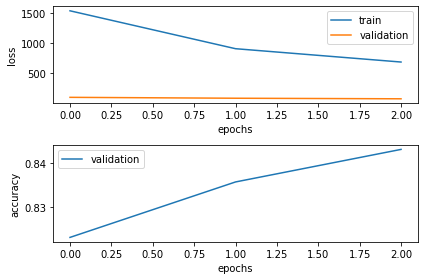

In [ ]:
plt.subplot(2, 1, 1)
plt.plot([train_loss for _, train_loss, _, _ in history], label="train")
plt.plot([eval_loss for _, _, eval_loss, _ in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")

plt.subplot(2, 1, 2)
plt.plot([eval_score for _, _, _, eval_score in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")

plt.tight_layout()
_ = plt.show()

## Evaluation

In [ ]:
ytrue, ypred = [], []
for batch in test_dl:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)
      predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
      labels = batch["labels"].cpu().numpy()
      ytrue.extend(labels)
      ypred.extend(predictions)

print("test accuracy: {:.3f}".format(accuracy_score(ytrue, ypred)))

test accuracy: 0.845


In [ ]:
print(classification_report(ytrue, ypred, target_names=valid_relations))

                          precision    recall  f1-score   support

administrative_divisions       0.67      0.81      0.73       463
                 capital       0.83      0.71      0.77       597
                 company       0.97      0.98      0.97       409
                 country       0.97      0.97      0.97       458
             nationality       0.94      0.91      0.93       527
         neighborhood_of       0.98      1.00      0.99       364
             place_lived       0.85      0.86      0.86       562
          place_of_birth       0.55      0.51      0.53       223
          place_of_death       0.44      0.49      0.46       110

                accuracy                           0.84      3713
               macro avg       0.80      0.80      0.80      3713
            weighted avg       0.85      0.84      0.85      3713



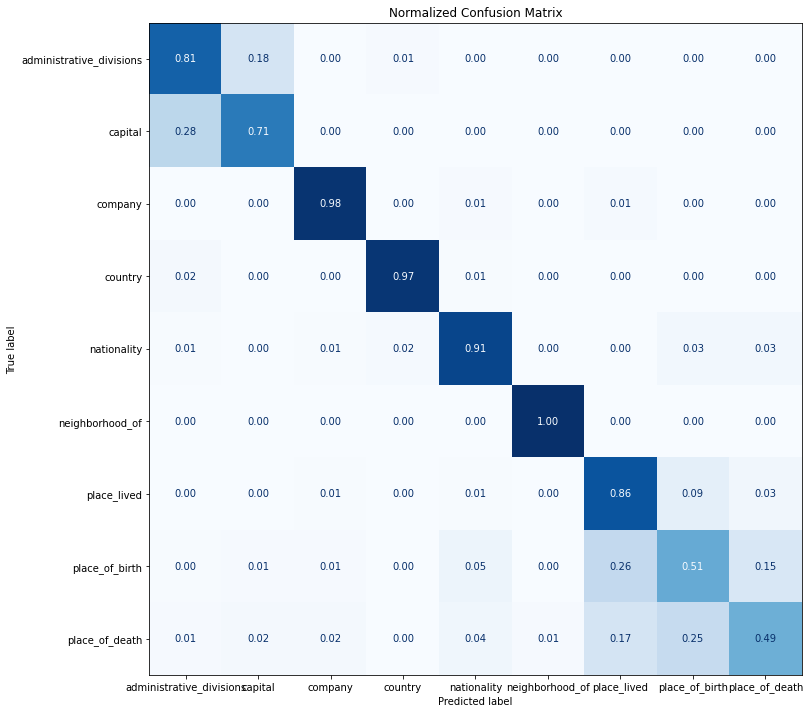

In [ ]:
def plot_confusion_matrix(ytrue, ypreds, labels):
  cm = confusion_matrix(ytrue, ypreds, normalize="true")
  fig, ax = plt.subplots(figsize=(12, 12))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format="0.2f", ax=ax, colorbar=False)
  plt.title("Normalized Confusion Matrix")
  _ = plt.show()


plot_confusion_matrix(ytrue, ypred, valid_relations)

## Save Model

In [ ]:
!cp -r data/bert-base-cased-nyt-re/ /content/drive/MyDrive/odsc-2022-data/NYT/

cp: cannot stat 'data/bert-base-cased-nyt-re/': No such file or directory


In [ ]:
!ls /content/drive/MyDrive/odsc-2022-data/NYT/bert-base-cased-nyt-re/

ckpt-1	ckpt-2	ckpt-3	history.tsv
